In [27]:
import tensorflow as tf
import numpy as np
import json
import re
import string

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

tf.__version__

'2.3.0'

In [15]:
#used google colab
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-09-14 11:08:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  21.5MB/s    in 0.3s    

2020-09-14 11:08:15 (21.5 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [16]:
with open("/tmp/sarcasm.json", 'r') as f:
  data = json.load(f)

In [17]:
for item in data:
  print(item)
  break

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


In [18]:
sentences = []
labels = []

for item in data:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [19]:
len(sentences)

26709

Total no.of examples are 26709. 

Let's split the dataset into training & test set, by considering some training size

In [20]:
training_size = 20000

train_data = sentences[0:training_size]
test_data = sentences[training_size:]

train_labels = labels[0:training_size]
test_labels = labels[training_size:]

In [22]:
train_data[:20]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way',
 "advancing the world's women",
 'the fascinating case for eating lab-grown meat',
 'this ceo will send your kids to school, if you work for his company',
 'top snake handler leaves sinking huckabee campaign',
 "friday's morning email: inside trump's presser for the ages",
 'airline passengers tackle man who rushes cockpit in bomb threat',
 'facebook reportedly working on healthcare features and apps',
 "north korea praises trump and urges us voters to reject 'dull hillary'",
 "actually, cnn's jeffrey lord has been 'indefensible' for a while",
 'barcelona holds huge protest in su

In [33]:
def text_preprocessing(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(r"\'","",text) # convert firend's to friends
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?:\S+|www.\S+', '', text)  # remove urls 
    text = re.sub('<.*?>+', '', text)  # remove html tags
    # text = re.sub('[^a-zA-Z]', ' ', text) #remove non alphabetical characters
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  #remove punctuations
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
  
    return text

In [34]:
train_data_final = [text_preprocessing(sent) for sent in train_data]
test_data_final = [text_preprocessing(sent) for sent in test_data]

In [35]:
train_data_final[:10]

['former versace store clerk sues over secret black code for minority shoppers',
 'the roseanne revival catches up to our thorny political mood  for better and worse',
 'mom starting to fear sons web series closest thing she will have to grandchild',
 'boehner just wants wife to listen  not come up with alternative debt reduction ideas',
 'j k  rowling wishes snape happy birthday in the most magical way',
 'advancing the worlds women',
 'the fascinating case for eating lab grown meat',
 'this ceo will send your kids to school  if you work for his company',
 'top snake handler leaves sinking huckabee campaign',
 'fridays morning email  inside trumps presser for the ages']

In [36]:
vocab_size = 10000
oov_tok = "<OOV>"
embedding_dim = 32
max_length = 120
trunc_type = 'post'
pad_type = 'post'

In [49]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

##Model with preprocessed data

In [47]:
tokens = Tokenizer(num_words = vocab_size, oov_token = oov_tok )
tokens.fit_on_texts(train_data_final)
word_index = tokens.word_index
print("Length of word_index :",len(word_index))

train_sequences = tokens.texts_to_sequences(train_data_final)
train_padded = pad_sequences(train_sequences, maxlen = max_length, padding = pad_type, truncating = trunc_type)

test_sequences = tokens.texts_to_sequences(test_data_final)
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = pad_type, truncating = trunc_type)


Length of word_index : 22488


In [48]:
reverse_word_index = dict([(value,key) for (key, value) in word_index.items()])

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(train_padded[3]))
print(train_data_final[3])

boehner just wants wife to listen not come up with alternative debt reduction ideas ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
boehner just wants wife to listen  not come up with alternative debt reduction ideas


In [61]:
model = keras.Sequential([
                          keras.layers.Embedding(input_dim=vocab_size, output_dim = embedding_dim, input_length = max_length ),
                          keras.layers.GlobalAveragePooling1D(),
                          keras.layers.Dense(24, activation = 'relu'),
                          keras.layers.Dense(1, activation = 'sigmoid')])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 32)           320000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 320,817
Trainable params: 320,817
Non-trainable params: 0
_________________________________________________________________


In [62]:
from tensorflow.keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [63]:
num_epochs = 100
history= model.fit(x=train_padded, y=train_labels, epochs = num_epochs, batch_size = 32,
          validation_data = (test_padded, test_labels), verbose = 2,
          callbacks = [earlystop])

Epoch 1/100
625/625 - 3s - loss: 0.6437 - accuracy: 0.6241 - val_loss: 0.5044 - val_accuracy: 0.7971
Epoch 2/100
625/625 - 3s - loss: 0.3938 - accuracy: 0.8407 - val_loss: 0.3780 - val_accuracy: 0.8417
Epoch 3/100
625/625 - 3s - loss: 0.3010 - accuracy: 0.8798 - val_loss: 0.3569 - val_accuracy: 0.8489
Epoch 4/100
625/625 - 3s - loss: 0.2533 - accuracy: 0.9006 - val_loss: 0.3556 - val_accuracy: 0.8460
Epoch 5/100
625/625 - 3s - loss: 0.2179 - accuracy: 0.9174 - val_loss: 0.3644 - val_accuracy: 0.8423
Epoch 6/100
625/625 - 3s - loss: 0.1933 - accuracy: 0.9266 - val_loss: 0.3690 - val_accuracy: 0.8474
Epoch 7/100
625/625 - 3s - loss: 0.1704 - accuracy: 0.9365 - val_loss: 0.3949 - val_accuracy: 0.8416
Epoch 8/100
625/625 - 3s - loss: 0.1538 - accuracy: 0.9448 - val_loss: 0.4037 - val_accuracy: 0.8462
Epoch 9/100
625/625 - 3s - loss: 0.1403 - accuracy: 0.9510 - val_loss: 0.4403 - val_accuracy: 0.8380


In [64]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
import matplotlib.pyplot as plt

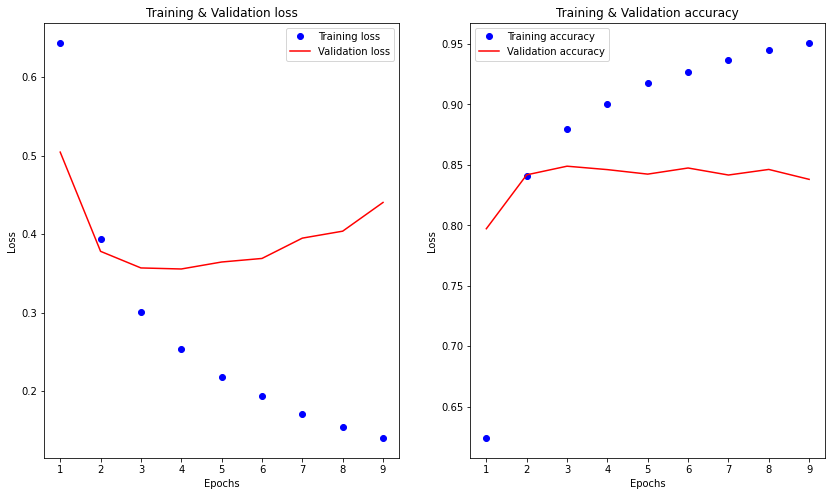

In [70]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (14,8)) 

ax1.plot(epochs, loss, 'bo', label='Training loss') # "bo" is for "blue dot"
ax1.plot(epochs, val_loss, 'r', label='Validation loss') # r is for "solid red line"
ax1.set_title('Training & Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training accuracy') # "bo" is for "blue dot"
ax2.plot(epochs, val_acc, 'r', label='Validation accuracy') # r is for "solid red line"
ax2.set_title('Training & Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

**Validation loss > Training loss & Validation accuracy < Training accuracy. It's a clear cut case of overfitting and we can use other techniques like Dropout or RNNs to reduce the overfitting.**

##Model without preprocessed data

In [74]:
tokens_new = Tokenizer(num_words = vocab_size, oov_token = oov_tok )
tokens_new.fit_on_texts(train_data)
word_index_new = tokens.word_index
print("Length of word_index :",len(word_index_new))

train_sequences = tokens_new.texts_to_sequences(train_data)
train_padded_new = pad_sequences(train_sequences, maxlen = max_length, padding = pad_type, truncating = trunc_type)

test_sequences = tokens_new.texts_to_sequences(test_data)
test_padded_new = pad_sequences(test_sequences, maxlen = max_length, padding = pad_type, truncating = trunc_type)

reverse_word_index_new = dict([(value,key) for (key, value) in word_index_new.items()])

def decode_review_new(text):
  return ' '.join([reverse_word_index_new.get(i, '?') for i in text])

print(decode_review_new(train_padded[3]))
print(train_data[3])

Length of word_index : 25637
boehner just wants wife to listen not come up with alternative debt reduction ideas ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
boehner just wants wife to listen, not come up with alternative debt-reduction ideas


In [82]:
model_new = keras.Sequential([
                          keras.layers.Embedding(input_dim=vocab_size, output_dim = embedding_dim, input_length = max_length ),
                          keras.layers.GlobalAveragePooling1D(),
                          keras.layers.Dense(24, activation = 'relu'),
                          keras.layers.Dense(1, activation = 'sigmoid')])

model_new.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_new.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 32)           320000    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 25        
Total params: 320,817
Trainable params: 320,817
Non-trainable params: 0
_________________________________________________________________


In [83]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto')
num_epochs = 100

history_new = model_new.fit(x=train_padded_new, y=train_labels, epochs = num_epochs, batch_size = 32,
          validation_data = (test_padded_new, test_labels), verbose = 2,
          callbacks = [earlystop])


Epoch 1/100
625/625 - 3s - loss: 0.6429 - accuracy: 0.6221 - val_loss: 0.5112 - val_accuracy: 0.8091
Epoch 2/100
625/625 - 3s - loss: 0.3937 - accuracy: 0.8450 - val_loss: 0.3707 - val_accuracy: 0.8453
Epoch 3/100
625/625 - 3s - loss: 0.2952 - accuracy: 0.8831 - val_loss: 0.3455 - val_accuracy: 0.8551
Epoch 4/100
625/625 - 3s - loss: 0.2471 - accuracy: 0.9024 - val_loss: 0.3437 - val_accuracy: 0.8517
Epoch 5/100
625/625 - 3s - loss: 0.2133 - accuracy: 0.9166 - val_loss: 0.3449 - val_accuracy: 0.8575
Epoch 6/100
625/625 - 3s - loss: 0.1856 - accuracy: 0.9298 - val_loss: 0.3610 - val_accuracy: 0.8517
Epoch 7/100
625/625 - 3s - loss: 0.1658 - accuracy: 0.9369 - val_loss: 0.3688 - val_accuracy: 0.8542
Epoch 8/100
625/625 - 3s - loss: 0.1464 - accuracy: 0.9456 - val_loss: 0.4036 - val_accuracy: 0.8435
Epoch 9/100
625/625 - 3s - loss: 0.1307 - accuracy: 0.9540 - val_loss: 0.4087 - val_accuracy: 0.8505
Epoch 10/100
625/625 - 3s - loss: 0.1210 - accuracy: 0.9556 - val_loss: 0.4307 - val_accura

In [84]:
history_dict_new = history.history
history_dict_new.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

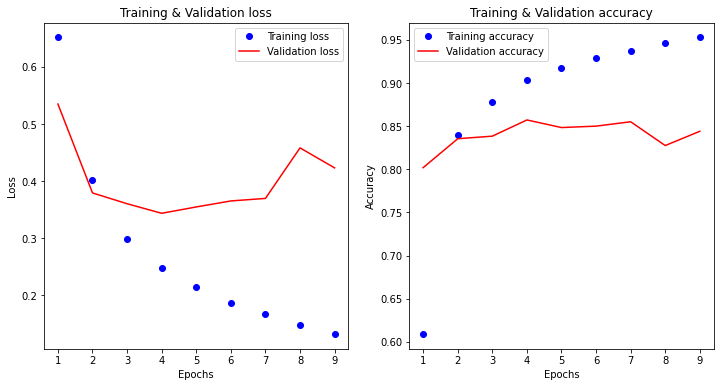

In [85]:
acc = history_dict_new['accuracy']
val_acc = history_dict_new['val_accuracy']
loss = history_dict_new['loss']
val_loss = history_dict_new['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,6)) 

ax1.plot(epochs, loss, 'bo', label='Training loss') # "bo" is for "blue dot"
ax1.plot(epochs, val_loss, 'r', label='Validation loss') # r is for "solid red line"
ax1.set_title('Training & Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'bo', label='Training accuracy') # "bo" is for "blue dot"
ax2.plot(epochs, val_acc, 'r', label='Validation accuracy') # r is for "solid red line"
ax2.set_title('Training & Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

There is no significant difference in validation accuracies from both the models. I will be using the first model to visualize the word embeddings

##Model prediction

###Prediction with preprocessed data model

In [89]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokens.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)
print(model.predict(padded))

[[0.7247011]
 [0.6561785]]


###Prediction with w/o preprocessed data model

In [88]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences_new = tokens_new.texts_to_sequences(sentence)
padded_new = pad_sequences(sequences_new, maxlen=max_length, padding=pad_type, truncating=trunc_type)
print(model_new.predict(padded))

[[0.8405017 ]
 [0.02489761]]


**It seems Model w/o preprocessed data has done the better job in predicting the new text**

##Visualizing Word Embeddings

To plot the vectors in 3D space (visulaizing word_embeddings) in [tensorflow projector](https://projector.tensorflow.org/)
- Get the weights from the embedding layer
- With the help of reverse_word_index function, write word ('meta.tsv') & word_vec('vecs.tsv')files
- Download those files & uploaded to [tensorflow projector](https://projector.tensorflow.org/)

In [ ]:
embed = model.layers[0]
weights = embed.get_weights()[0]
print("Embed_weights_shape :", weights.shape)

import io

out_word_vec = io.open('vecs.tsv', 'w', encoding='utf-8')
out_words = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1,weights.shape[0]):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_words.write(word + '\n')
  out_word_vec.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_word_vec.close()
out_words.close()

If you are working on google colab then please do use the below code to download the files

In [24]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>